In [70]:
%pip install matplotlib sklearn pandas scikit-image

Note: you may need to restart the kernel to use updated packages.


In [71]:
import torchvision as thv
import torch 
from torchvision import models
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from torchvision.transforms import ToTensor, Compose, RandomCrop, Resize, Normalize
from torch.optim.lr_scheduler import ExponentialLR
import random
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from torch.utils.data import TensorDataset, DataLoader, random_split
import matplotlib.pyplot as plt
from skimage import io, color
import os


In [72]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [73]:
fitzDF = pd.read_csv('./fitzpatrick17k.csv') 
fitzDF.head(5)

,Unnamed: 0,md5hash,fitzpatrick,label,nine_partition_label,three_partition_label,qc,url,url_alphanum
0,0,5e82a45bc5d78bd24ae9202d194423f8,3,drug induced pigmentary changes,inflammatory,non-neoplastic,NaN,https://www.dermaamin.com/site/images/clinical...,httpwwwdermaamincomsiteimagesclinicalpicmminoc...
1,1,fa2911a9b13b6f8af79cb700937cc14f,1,photodermatoses,inflammatory,non-neoplastic,NaN,https://www.dermaamin.com/site/images/clinical...,httpwwwdermaamincomsiteimagesclinicalpicpphoto...
2,2,d2bac3c9e4499032ca8e9b07c7d3bc40,2,dermatofibroma,benign dermal,benign,NaN,https://www.dermaamin.com/site/images/clinical...,httpwwwdermaamincomsiteimagesclinicalpicdderma...
3,3,0a94359e7eaacd7178e06b2823777789,1,psoriasis,inflammatory,non-neoplastic,NaN,https://www.dermaamin.com/site/images/clinical...,httpwwwdermaamincomsiteimagesclinicalpicppsori...
4,4,a39ec3b1f22c08a421fa20535e037bba,1,psoriasis,inflammatory,non-neoplastic,NaN,https://www.dermaamin.com/site/images/clinical...,httpwwwdermaamincomsiteimagesclinicalpicppsori...


In [74]:
transform=transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
            transforms.RandomRotation(degrees=15),
            transforms.ColorJitter(),
            transforms.RandomHorizontalFlip(),
            transforms.CenterCrop(size=224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],
                                [0.229, 0.224, 0.225])
            ])

imgListOfTensors = []

for md5hash in fitzDF.md5hash:
    if os.path.exists('./finalfitz17k/' + md5hash + '.jpg'):

        img = io.imread('./finalfitz17k/' + md5hash + '.jpg')
        if(len(img.shape) < 3):
            img = color.gray2rgb(img)
        image = transform(img)
        imgListOfTensors += [image]
    else:
        fitzDF = fitzDF.drop(md5hash)
imgListOfTensors = torch.stack(imgListOfTensors)
print(imgListOfTensors.shape)

torch.Size([16577, 3, 224, 224])


In [75]:
diagnosis = fitzDF.three_partition_label.values

tempList = []

for i in range(len(diagnosis)):
    if diagnosis[i] == 'non-neoplastic':
        temp = [1, 0, 0]
    elif diagnosis[i] == 'benign':
        temp = [0, 1, 0]
    elif diagnosis[i] == 'malignant':
        temp = [0, 0, 1]
    tempList += [temp]
diagnosisNP = np.array(tempList)

In [76]:
xDataNP = imgListOfTensors.numpy()
yDataNP = diagnosisNP
X_train, X_test, y_train, y_test = train_test_split(xDataNP, yDataNP, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

train_data = TensorDataset(torch.from_numpy(X_train).to(device), torch.from_numpy(y_train).to(device))
val_data = TensorDataset(torch.from_numpy(X_val).to(device), torch.from_numpy(y_val).to(device))
test_data = TensorDataset(torch.from_numpy(X_test).to(device), torch.from_numpy(y_test).to(device))

In [99]:
model = models.resnet50(pretrained=True).to(device)

for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Sequential(
    nn.Linear(2048, 1024),
    nn.ReLU(),
    nn.Linear(1024, 224),
    nn.ReLU(),
    nn.Linear(224, 3)).to(device)

In [100]:
EPOCHS = 20
batch_size = 32
learning_rate = 0.0001

#model = ResNet()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=learning_rate)

In [79]:

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, drop_last=True)

In [80]:
def Train(model, loader, optimizer, criterion):
  epoch_loss = []
  model.train()
  for data, labels in loader:
    optimizer.zero_grad()
    predictions = model(data)
    loss = criterion(predictions,labels.float())
    epoch_loss.append(loss.item())
    loss.backward()
    optimizer.step()
    
  return np.mean(epoch_loss)

In [81]:
def Validation(model, loader, criterion):
  epoch_loss = []
  epoch_acc = 0

  model.eval()
  with torch.no_grad():
    for text, labels in loader:
      output = model(text)

      loss = criterion(output, labels.float())
      epoch_loss.append(loss.item())
      preds = output.argmax(dim=1)
      labels = labels.argmax(dim=1)
      epoch_acc += (preds == labels).cpu().sum()

  return np.mean(epoch_loss), epoch_acc/len(loader.dataset)

In [101]:
train_loss = []
val_loss = []
val_acc = []

for epoch in range(EPOCHS):
  trainEpochLoss = Train(model, train_loader, optimizer, criterion)
  valEpochLoss, valEpochAcc = Validation(model, val_loader, criterion)
  val_loss.append(valEpochLoss)
  val_acc.append(valEpochAcc)
  train_loss.append(trainEpochLoss)

  print(f'Epoch: {epoch} Train Loss: {trainEpochLoss}  VAL Loss: {valEpochLoss} Acc: {valEpochAcc}')

Epoch: 0 Train Loss: 0.7158800343732459  VAL Loss: 0.6341748081329392 Acc: 0.7663022875785828
Epoch: 1 Train Loss: 0.6565161160111788  VAL Loss: 0.6251912055219092 Acc: 0.7602713704109192
Epoch: 2 Train Loss: 0.6400229467185963  VAL Loss: 0.6297116966509237 Acc: 0.7655484080314636
Epoch: 3 Train Loss: 0.6283923659439894  VAL Loss: 0.6027840830203963 Acc: 0.7674331068992615
Epoch: 4 Train Loss: 0.6099928125874153  VAL Loss: 0.6254182348891002 Acc: 0.7644176483154297
Epoch: 5 Train Loss: 0.5972508488284857  VAL Loss: 0.5799080449633482 Acc: 0.7708255052566528
Epoch: 6 Train Loss: 0.5786811894430495  VAL Loss: 0.5753111961047824 Acc: 0.7757256031036377
Epoch: 7 Train Loss: 0.5669099313975101  VAL Loss: 0.6094673421324753 Acc: 0.7779871821403503
Epoch: 8 Train Loss: 0.5438740101285572  VAL Loss: 0.5615559056764696 Acc: 0.7813795804977417
Epoch: 9 Train Loss: 0.5279873225984256  VAL Loss: 0.5531851482100603 Acc: 0.7885412573814392
Epoch: 10 Train Loss: 0.5138147625498181  VAL Loss: 0.620510

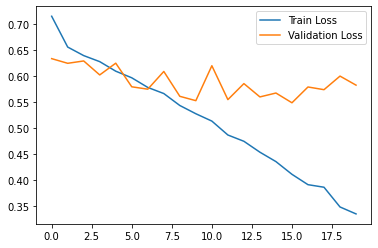

In [102]:
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.show()

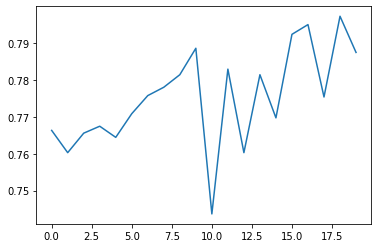

In [103]:
plt.plot(val_acc, label='Validation Acc')
plt.show()

In [104]:
torch.cuda.empty_cache()